# Yield calculation

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
import sklearn.preprocessing as sklp

%matplotlib inline
plt.rcParams.update({'font.size': 20})
mpl.style.use('fivethirtyeight')

### Regression coefficients

In [2]:
# Get coefficients
coeff = pd.read_csv('../GMFD_all/fitting/gmfd_regression_res_60-05_n5k.csv')
coeff['GEOID'] = coeff['GEOID'].astype(str).str.zfill(5)
good_counties = coeff.query('pval < 0.05')['GEOID'].values

In [3]:
coeff.head()

,GEOID,GDDc,KDDc,Pc,P2c,R2,pval
0,01001,0.000250,-0.008723,0.703101,-0.407163,0.422681,7.485535e-05
1,01003,0.000007,-0.002706,0.382554,-0.067899,0.166723,9.083721e-02
2,01005,0.000056,-0.005908,1.418518,-0.874680,0.367972,4.632079e-04
3,01007,0.000113,-0.006301,0.907473,-0.574074,0.215380,5.608200e-02
4,01009,0.000457,-0.009639,0.033484,-0.552033,0.593670,5.365933e-08


In [5]:
# Diffenbaugh et al
GDDc = 0.000315512
KDDc = -0.00643807
Pc = 100*0.0102821
P2c = 100*-0.000081514
diffen = np.array([GDDc, KDDc, Pc, P2c])

## GMFD

In [6]:
# Import GMFD data
gmfd = pd.read_csv('./raw/GMFD/agvar_historical_gmfd.csv')
gmfd = gmfd.query('Year >= 2006 and Year <= 2016')
gmfd.sort_values(by = ['GEOID', 'Year'], inplace = True)
gmfd['GEOID'] = gmfd['GEOID'].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd.set_index(['GEOID', 'Year'], inplace = True)

In [7]:
# Subtract means
for agvar in gmfd.columns:
    gmfd[agvar] = gmfd[agvar] - gmfd[agvar].mean(level = 'GEOID')

In [8]:
gmfd

gdd       egdd      prcp     prcp2
GEOID Year                                           
01001 2006    4.726345  26.566847 -0.214764 -0.283854
      2007    8.849976  31.636496 -0.384405 -0.416301
      2008  -91.122431 -20.499031  0.102285  0.117987
      2009  -31.897592 -33.802521  0.224311  0.326226
      2010    6.120089  36.589416 -0.062858 -0.116409
...                ...        ...       ...       ...
56045 2012  234.291448  39.736328 -0.108562 -0.057078
      2013    9.251826 -13.109958 -0.038376 -0.024961
      2014 -104.457415 -27.874133  0.017893  0.007903
      2015  -25.506358 -21.060937  0.128836  0.091250
      2016   -8.042474  -6.686181 -0.021301 -0.015658

[34188 rows x 4 columns]

In [9]:
# Calculate Yields
gmfd = pd.merge(coeff, gmfd.reset_index(), on = ['GEOID'], how = 'inner')
gmfd.set_index(['GEOID', 'Year'], inplace = True)
gmfd['GMFD'] = gmfd['gdd']*gmfd['GDDc'] + gmfd['egdd']*gmfd['KDDc'] + gmfd['prcp']*gmfd['Pc'] + gmfd['prcp2']*gmfd['P2c']
gmfd = gmfd.filter(['GEOID', 'Year', 'GMFD'])

In [10]:
gmfd.head()

GMFD
GEOID Year          
01001 2006 -0.265990
      2007 -0.374531
      2008  0.179931
      2009  0.311781
      2010 -0.314442

In [20]:
gmfd.mean(level = 'GEOID')

,GMFD
GEOID,
01001,1.072375e-16
01003,-1.154380e-16
01005,-3.961478e-16
01007,3.154043e-16
01009,-4.314730e-16
...,...
56027,-1.980739e-16
56029,5.361873e-18
56031,-2.895411e-16


In [21]:
gmfd.loc['05007']

,GMFD
Year,
2006,-0.038970
2007,0.038493
2008,0.074667
2009,0.155369
2010,-0.010462
2011,-0.236987
2012,-0.419176
2013,0.171591
2014,0.036111


In [11]:
# Save
gmfd.to_csv('./final/GMFD/res_yield_06-16_gmfd_n5k.csv')

## Check against USDA

In [13]:
# USDA
usda = pd.read_csv('../USDA/final/USDA_county_yields_w_county_quad_trends.csv')
usda = usda.query("year >= 1960 and year <= 2005")
usda["GEOID"] = usda["state_fips_code"].astype(str).str.zfill(2) + usda["county_code"].astype(str).str.zfill(3)
usda.sort_values(by = ['GEOID', 'year'], inplace = True)
usda.set_index(['GEOID', 'year'], inplace = True)

In [14]:
usda.head()

state_fips_code  county_code  asd_code  Value     area  log_Value  \
GEOID year                                                                      
01001 1960                1            1        40   28.0  20100.0   3.332205   
      1961                1            1        40   32.0  16700.0   3.465736   
      1962                1            1        40   25.0  15450.0   3.218876   
      1963                1            1        40   36.0  16000.0   3.583519   
      1964                1            1        40   33.0  16100.0   3.496508   

            lowess_log_Value  quad_fit  quad_fit_nolog  target_Value  \
GEOID year                                                             
01001 1960          3.257429   3.18457       25.872351      0.074776   
      1961          3.303342   3.20547       25.805471      0.162394   
      1962          3.349108   3.22663       25.804917     -0.130232   
      1963          3.394685   3.24805       25.870688      0.188834   
      1964          3.439928   3.26973       26.002784      0.056579   

            target_ValueQ  target_ValueQnl  
GEOID year                                  
01001 1960       0.147635         2.127649  
      1961       0.260266         6.194529  
      1962      -0.007754        -0.804917  
      1963       0.335469        10.129312  
      1964       0.226777         6.997216

In [15]:
# Subtract means
usda['target_ValueQ'] = usda['target_ValueQ'] - usda['target_ValueQ'].mean(level = 'GEOID')

In [16]:
# Merge
data = pd.merge(gmfd.reset_index(), usda.filter(['target_ValueQ', 'log_Value']).reset_index(), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year'], how = 'inner').drop(columns = ['year'])
data.set_index(['GEOID', 'Year'], inplace = True)

In [17]:
data.head()

GMFD  target_ValueQ  log_Value
GEOID Year                                    
01001 1960 -0.149831       0.121670   3.332205
      1961  0.231540       0.234301   3.465736
      1962 -0.489502      -0.033719   3.218876
      1963 -0.091325       0.309504   3.583519
      1964  0.108570       0.200813   3.496508

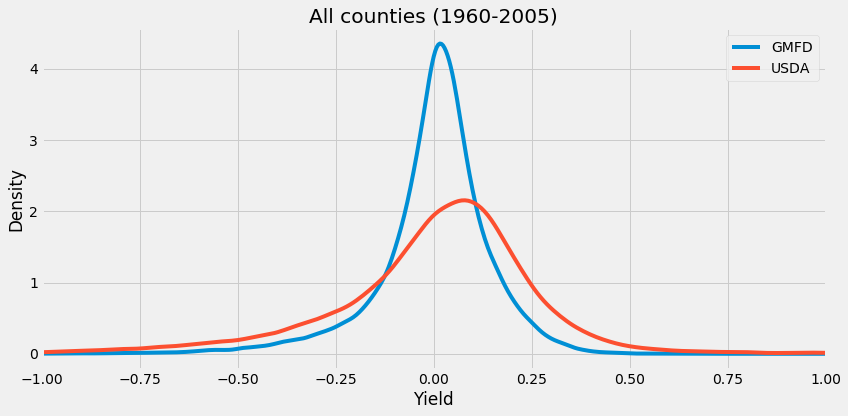

In [18]:
# Plot all counties
fig, ax = plt.subplots(1,1, figsize = (12,6))
data['GMFD'].plot(kind = 'density', xlim = [-1,1], ax = ax, label = 'GMFD')
data['target_ValueQ'].plot(kind = 'density', xlim = [-1,1], ax = ax, label = 'USDA')
ax.set_xlabel('Yield')
ax.set_title('All counties (1960-2005)')
plt.legend()
plt.tight_layout()
plt.show()

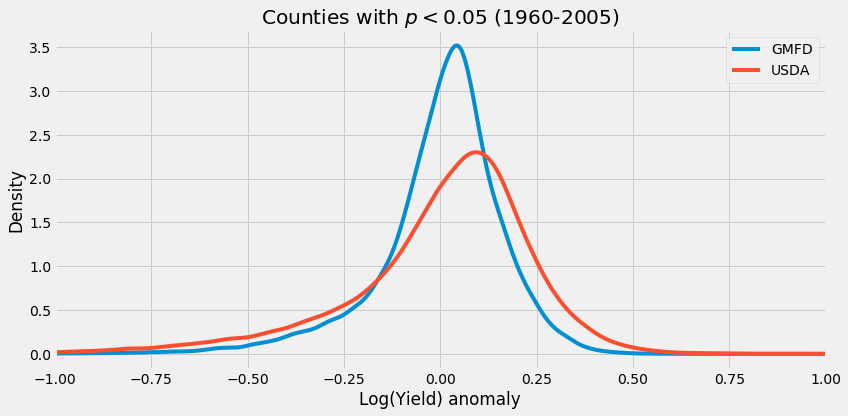

In [19]:
# Plot select counties
fig, ax = plt.subplots(1,1, figsize = (12,6))
data.loc[good_counties]['GMFD'].plot(kind = 'kde', xlim = [-1,1], ax = ax)
data.loc[good_counties]['target_ValueQ'].plot(kind = 'kde', xlim = [-1,1], ax = ax, label = 'USDA')
ax.set_xlabel('Log(Yield) anomaly')
ax.set_title('Counties with $p < 0.05$ (1960-2005)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# USDA weights
usda_weights = pd.read_csv("../../analysis/national/weights/usda_county_to_national_weights.csv")
usda_weights["GEOID"] = usda_weights["GEOID"].astype(str).str.zfill(5)

In [21]:
usda_weights.head()

,GEOID,year,Value,area,national_weight
0,01001,1950,17.0,29600.0,0.000211
1,01011,1950,11.0,24200.0,0.000111
2,01047,1950,13.0,44200.0,0.000241
3,01051,1950,23.0,38900.0,0.000375
4,01063,1950,16.0,23900.0,0.000160


In [22]:
# Merge
gmfd_weighted = pd.merge(gmfd.reset_index(), usda.reset_index().filter(['GEOID', 'year', 'target_ValueQ', 'quad_fit', 'log_Value']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year'])
gmfd_weighted = pd.merge(gmfd_weighted, usda_weights.filter(['GEOID', 'year', 'national_weight']), left_on = ['GEOID', 'Year'], right_on = ['GEOID', 'year']).drop(columns = ['year_x', 'year_y'])

In [23]:
gmfd_weighted

,GEOID,Year,GMFD,target_ValueQ,quad_fit,log_Value,national_weight
0,01001,1960,-0.149831,0.121670,3.184570,3.332205,1.469247e-04
1,01001,1961,0.231540,0.234301,3.205470,3.465736,1.511315e-04
2,01001,1962,-0.489502,-0.033719,3.226630,3.218876,1.088743e-04
3,01001,1963,-0.091325,0.309504,3.248050,3.583519,1.447571e-04
4,01001,1964,0.108570,0.200813,3.269730,3.496508,1.537549e-04
...,...,...,...,...,...,...,...
122181,56041,1974,NaN,-0.455350,3.856547,3.401197,1.276220e-06
122182,56041,1975,NaN,-0.172053,3.727401,3.555348,1.198732e-06
122183,56041,1976,NaN,0.293675,3.618348,3.912023,7.953683e-07
122184,56041,1995,NaN,-0.017118,5.364225,5.347108,1.396224e-06


In [24]:
# Sum
gmfd_weighted.rename(columns = {'GMFD_x' : 'GMFD'}, inplace=True)
gmfd_weighted['GMFD'] = gmfd_weighted['GMFD'] * gmfd_weighted['national_weight']
gmfd_weighted['target_ValueQ'] = gmfd_weighted['target_ValueQ'] * gmfd_weighted['national_weight']
gmfd_weighted['quad_fit'] = gmfd_weighted['quad_fit'] * gmfd_weighted['national_weight']
gmfd_weighted['log_Value'] = gmfd_weighted['log_Value'] * gmfd_weighted['national_weight']
gmfd_weighted = gmfd_weighted.groupby('Year').sum()

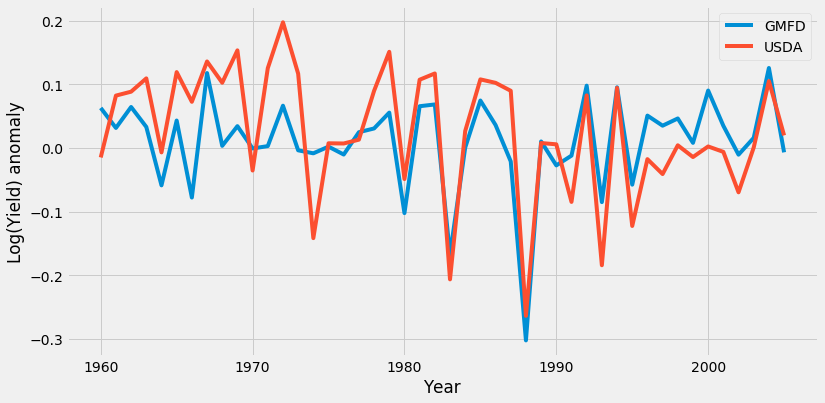

In [25]:
# Plot national
fig, ax = plt.subplots(1,1, figsize = (12,6))
gmfd_weighted['GMFD'].plot(ax = ax)
gmfd_weighted['target_ValueQ'].plot(ax = ax, label = 'USDA')
ax.set_ylabel('Log(Yield) anomaly')
plt.legend()
plt.show()

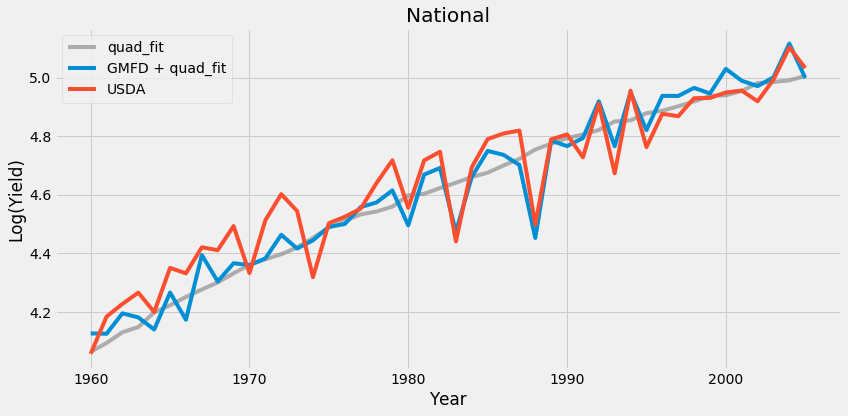

In [26]:
# Plot
fig, ax = plt.subplots(1,1, figsize = (12,6))
gmfd_weighted['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6)
ax.plot(gmfd_weighted.index, gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'], label = 'GMFD + quad_fit')
gmfd_weighted['log_Value'].plot(ax = ax, label = 'USDA', color = 'C1')
ax.set_ylabel('Log(Yield)')
ax.set_title('National')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# R-squared
n = len(gmfd_weighted)
p1 = 2
r2 = r2_score(gmfd_weighted['log_Value'], gmfd_weighted['quad_fit'])
print('R-squared: ' + str(r2))
print('Adj. R-squared: ' + str(1. - (1. - r2)*((n-1)/(n-p1-1))))

R-squared: 0.8369977404623281
Adj. R-squared: 0.8294162400187155


In [28]:
# R-squared
n = len(gmfd_weighted)
p2 = 6
r2 = r2_score(gmfd_weighted['log_Value'], gmfd_weighted['quad_fit'] + gmfd_weighted['GMFD'])
print('R-squared: ' + str(r2))
print('Adj. R-squared: ' + str(1. - (1. - r2)*((n-1)/(n-p2-1))))

R-squared: 0.9224988478458385
Adj. R-squared: 0.9105755936682751


In [29]:
# F-test
import scipy.stats as ss
SSEbase = np.sum(gmfd_weighted['target_ValueQ']**2)
SSEfull = np.sum((gmfd_weighted['GMFD'] - gmfd_weighted['target_ValueQ'])**2)
F = ((SSEbase - SSEfull)/(p2-p1))/(SSEfull/(n-p2-1))

In [30]:
print('F-statistic:')
print(F)
print('p-value:')
print(ss.f.sf(F, p2-p1, n-p2-1))

F-statistic:
11.059930333425285
p-value:
4.313541302711506e-06


## NEX

In [2]:
nex_hist = ["agvar_historical_r1i1p1_ACCESS1-0.csv",
"agvar_historical_r1i1p1_BNU-ESM.csv",
"agvar_historical_r1i1p1_CCSM4.csv",
"agvar_historical_r1i1p1_CESM1-BGC.csv",
"agvar_historical_r1i1p1_CNRM-CM5.csv",
"agvar_historical_r1i1p1_CSIRO-Mk3-6-0.csv",
"agvar_historical_r1i1p1_CanESM2.csv",
"agvar_historical_r1i1p1_GFDL-CM3.csv",
"agvar_historical_r1i1p1_GFDL-ESM2G.csv",
"agvar_historical_r1i1p1_GFDL-ESM2M.csv",
"agvar_historical_r1i1p1_IPSL-CM5A-LR.csv",
"agvar_historical_r1i1p1_IPSL-CM5A-MR.csv",
"agvar_historical_r1i1p1_MIROC-ESM-CHEM.csv",
"agvar_historical_r1i1p1_MIROC-ESM.csv",
"agvar_historical_r1i1p1_MIROC5.csv",
"agvar_historical_r1i1p1_MPI-ESM-LR.csv",
"agvar_historical_r1i1p1_MPI-ESM-MR.csv",
"agvar_historical_r1i1p1_MRI-CGCM3.csv",
"agvar_historical_r1i1p1_NorESM1-M.csv",
"agvar_historical_r1i1p1_bcc-csm1-1.csv",
"agvar_historical_r1i1p1_inmcm4.csv"]

nex_proj = ["agvar_rcp85_r1i1p1_ACCESS1-0.csv",
"agvar_rcp85_r1i1p1_BNU-ESM.csv",
"agvar_rcp85_r1i1p1_CCSM4.csv",
"agvar_rcp85_r1i1p1_CESM1-BGC.csv",
"agvar_rcp85_r1i1p1_CNRM-CM5.csv",
"agvar_rcp85_r1i1p1_CSIRO-Mk3-6-0.csv",
"agvar_rcp85_r1i1p1_CanESM2.csv",
"agvar_rcp85_r1i1p1_GFDL-CM3.csv",
"agvar_rcp85_r1i1p1_GFDL-ESM2G.csv",
"agvar_rcp85_r1i1p1_GFDL-ESM2M.csv",
"agvar_rcp85_r1i1p1_IPSL-CM5A-LR.csv",
"agvar_rcp85_r1i1p1_IPSL-CM5A-MR.csv",
"agvar_rcp85_r1i1p1_MIROC-ESM-CHEM.csv",
"agvar_rcp85_r1i1p1_MIROC-ESM.csv",
"agvar_rcp85_r1i1p1_MIROC5.csv",
"agvar_rcp85_r1i1p1_MPI-ESM-LR.csv",
"agvar_rcp85_r1i1p1_MPI-ESM-MR.csv",
"agvar_rcp85_r1i1p1_MRI-CGCM3.csv",
"agvar_rcp85_r1i1p1_NorESM1-M.csv",
"agvar_rcp85_r1i1p1_bcc-csm1-1.csv",
"agvar_rcp85_r1i1p1_inmcm4.csv"]

In [7]:
# Run calculation
def run_calc(name, hist=True, oos=False, mid=False, end=False):
    # Read in data
    data = pd.read_csv("./raw/NEX/" + name)
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    data.set_index(['GEOID', 'Year'], inplace=True)
    
    # Select time period
    if hist:
        data = data.query('Year >= 1960 and Year <= 2005')
    elif oos:
        data = data.query('Year >= 2006 and Year <= 2016')
    elif mid:
        data = data.query('Year >= 2040 and Year <= 2059')
    elif end:
        data = data.query('Year >= 2080 and Year <= 2099')
    
    # Square precip
    data['prcp2'] = data['prcp']**2
    
    # Subtract means
    for agvar in data.columns:
        data[agvar] = data[agvar] - data[agvar].mean(level = 'GEOID')

    # Calculate yields
    data = pd.merge(coeff, data.reset_index(), on = 'GEOID', how = 'outer')
    data['yield'] = data['gdd']*data['GDDc'] + data['egdd']*data['KDDc'] + data['prcp']*data['Pc'] + data['prcp2']*data['P2c']
#     data['yield'] = data['gdd']*diffen[0] + data['egdd']*diffen[1] + data['prcp']*diffen[2] + data['prcp2']*diffen[3]
    data = data.filter(['GEOID', 'Year', 'yield'])
    
    # Save
    timeID = hist*'60-05' + oos*'06-16' + mid*'40-59' + end*'80-99'
    data.to_csv("./final/NEX/res_" + timeID + '_yield_' + name[6:], index=False)

In [33]:
for model in nex_hist:
    run_calc(model)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
for model in nex_proj:
    run_calc(model, proj=False, hist=False, oos=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
for model in nex_proj:
    run_calc(model, hist=False, mid=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
for model in nex_proj:
    run_calc(model, hist=False, end=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## CMIP

In [10]:
cmip_all = ["agvar_ACCESS1-0.historical+rcp85.csv",
"agvar_BNU-ESM.historical+rcp85.csv",
"agvar_CCSM4_historical+rcp85.csv",
"agvar_CESM1-BGC.historical+rcp85.csv",
"agvar_CNRM-CM5.historical+rcp85.csv",
"agvar_CSIRO-Mk3-6-0.historical+rcp85.csv",
"agvar_CanESM2.historical+rcp85.csv",
"agvar_GFDL-CM3.historical+rcp85.csv",
"agvar_GFDL-ESM2G.historical+rcp85.csv",
"agvar_GFDL-ESM2M.historical+rcp85.csv",
"agvar_IPSL-CM5A-LR.historical+rcp85.csv",
"agvar_IPSL-CM5A-MR.historical+rcp85.csv",
"agvar_MIROC-ESM-CHEM.historical+rcp85.csv",
"agvar_MIROC-ESM.historical+rcp85.csv",
"agvar_MIROC5.historical+rcp85.csv",
"agvar_MPI-ESM-LR.historical+rcp85.csv",
"agvar_MPI-ESM-MR.historical+rcp85.csv",
"agvar_MRI-CGCM3.historical+rcp85.csv",
"agvar_NorESM1-M.historical+rcp85.csv",
"agvar_bcc-csm1-1_historical+rcp85.csv",
"agvar_inmcm4.historical+rcp85.csv"]

In [12]:
# Run calculation
def run_calc(name, hist=True, oos=False, mid=False, end=False):
    # Read in data
    data = pd.read_csv("./raw/CMIP/" + name)
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    data.set_index(['GEOID', 'Year'], inplace=True)
    
    # Select time period
    if hist:
        data = data.query('Year >= 1960 and Year <= 2005')
    elif oos:
        data = data.query('Year >= 2006 and Year <= 2016')
    elif mid:
        data = data.query('Year >= 2040 and Year <= 2059')
    elif end:
        data = data.query('Year >= 2080 and Year <= 2099')
    
    # Square precip
    data['prcp2'] = data['prcp']**2
    
    # Subtract means
    for agvar in data.columns:
        data[agvar] = data[agvar] - data[agvar].mean(level = 'GEOID')

    # Calculate yields
    data = pd.merge(coeff, data.reset_index(), on = 'GEOID', how = 'outer')
    data['yield'] = data['gdd']*data['GDDc'] + data['egdd']*data['KDDc'] + data['prcp']*data['Pc'] + data['prcp2']*data['P2c']
    data = data.filter(['GEOID', 'Year', 'yield'])
    
    # Save
    timeID = hist*'60-05' + oos*'06-16' + mid*'40-59' + end*'80-99'
    data.to_csv("./final/CMIP/res_" + timeID + '_yield_' + name[6:], index=False)

In [38]:
for model in cmip_all:
    run_calc(model)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
for model in cmip_all:
    run_calc(model, hist=False, oos=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
for model in cmip_all:
    run_calc(model, hist=False, mid=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
for model in cmip_all:
    run_calc(model, hist=False, end=True)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
